<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/E4P2S9_Updated_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Fri Nov 20 17:45:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Source : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torchtext import data

In [ ]:
SEED = 1234

torch.manual_seed(SEED)                      # We are using seed to ensure that we get similar data while splitting train & test data
torch.backends.cudnn.deterministic = True
txt = data.Field(tokenize = 'spacy', include_lengths = True)   
# 'include_lengths = True' will enable us to use pre-padded sequencing in RNN i.e. RNN will only process non-padded
# elements. Another difference will be batch.text will now be a tuple with (padded numericalized tensor, actual length of sentence)
lbl = data.LabelField(dtype = torch.float)

#### train_data is organized in such a way that a single element contains a field, 'text', along with all the tokens representing the text, and a 'label' field that contains the label of the text (eg: in this case POS, NEG for sentiment analysis)

In [ ]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(txt, lbl)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:04<00:00, 20.5MB/s]


In [ ]:
print('Length of train_data:',len(train_data), 'Type:', type(train_data))
print('Length of test_data :',len(test_data), 'Type:', type(test_data))
print(train_data.fields)
print(test_data.fields)
print(vars(train_data.examples[0]))   # vars -> Built-in function, with an argument equivalent to object.dict.
print(vars(test_data.examples[0])) 
print(vars(train_data[-1]))

Length of train_data: 25000 Type: torchtext.datasets.imdb.IMDB
Length of test_data : 25000 Type: torchtext.datasets.imdb.IMDB
{'text': <torchtext.data.field.Field object at 0x7f8709317940>, 'label': <torchtext.data.field.LabelField object at 0x7f864b73b080>}
{'text': <torchtext.data.field.Field object at 0x7f8709317940>, 'label': <torchtext.data.field.LabelField object at 0x7f864b73b080>}
{'text': ['After', 'losing', 'the', 'Emmy', 'for', 'her', 'performance', 'as', 'Mama', 'Rose', 'in', 'the', 'television', 'version', 'of', 'GYPSY', ',', 'Bette', 'won', 'an', 'Emmy', 'the', 'following', 'year', 'for', 'BETTE', 'MIDLER', ':', 'DIVA', 'LAS', 'VEGAS', ',', 'a', 'live', 'concert', 'special', 'filmed', 'for', 'HBO', 'from', 'Las', 'Vegas', '.', 'Midler', ',', 'who', 'has', 'been', 'performing', 'live', 'on', 'stage', 'since', 'the', '1970', "'s", ',', 'proves', 'that', 'she', 'is', 'still', 'one', 'of', 'the', 'most', 'electrifying', 'live', 'performers', 'in', 'the', 'business', '.', 'Fro

##### Split the train_data further into train_data & valid_data

In [ ]:
import random
train_data, valid_data = train_data.split(split_ratio=0.8,random_state=random.seed(SEED))

In [ ]:
print('Length of train_data:',len(train_data))
print('Length of valid_data:',len(valid_data))
print('Length of test_data:',len(test_data))

Length of train_data: 20000
Length of valid_data: 5000
Length of test_data: 25000


### Building vocabulary. We take only top 25,000 words. Rest will be replaced with 'unk'. Also we are going to use pre-trained vector glove.6B.100d. This means glove was trained on 6 Billion words & have 100 dimensions. unk_init is meant for initialization of out-of-vocabulary word vectors (<unk>). Please note that building vocabulary means building a dictionary of words from input document.

In [ ]:
max_vocab_size = 25_000
txt.build_vocab(train_data, max_size=max_vocab_size, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
lbl.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:29, 2.22MB/s]                           
 99%|█████████▉| 397844/400000 [00:15<00:00, 26109.44it/s]

In [ ]:
print('Unique words in txt:',len(txt.vocab))   # 25,002 words because of unk & pad. Pad is used to make batch_size same for shorter sentences
print('Unique words in lbl:',len(lbl.vocab))

Unique words in txt: 25002
Unique words in lbl: 2


In [ ]:
print(txt.vocab.freqs.most_common(25))  # Printing most commonly occuring 25 words

[('the', 231591), (',', 220110), ('.', 189374), ('a', 125362), ('and', 125134), ('of', 115176), ('to', 106945), ('is', 87093), ('in', 70127), ('I', 62105), ('it', 61215), ('that', 56406), ('"', 50319), ("'s", 49332), ('this', 48557), ('-', 42473), ('/><br', 40577), ('was', 40178), ('as', 34706), ('with', 34145), ('movie', 34138), ('for', 33681), ('film', 31061), ('The', 30221), ('but', 28021)]


## How to see vocabulary directly ? 
We can  see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.

In [ ]:
print(txt.vocab.itos[:10])     # First 10
print(txt.vocab.itos[77:90])   # In between
print(txt.vocab.itos[-10:])    # Last 10

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']
['story', 'were', 'see', 'their', 'even', 'no', 'me', 'does', 'my', 'did', 'than', '...', ':']
['grifters', 'grinds', 'grins', 'grittier', 'grotesquely', 'group.<br', 'grudgingly', 'guerrillas', 'guttural', 'guys.<br']


In [ ]:
print(txt.vocab.stoi)
print(lbl.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f86a1892bf8>, {'<unk>': 0, '<pad>': 1, 'the': 2, ',': 3, '.': 4, 'a': 5, 'and': 6, 'of': 7, 'to': 8, 'is': 9, 'in': 10, 'I': 11, 'it': 12, 'that': 13, '"': 14, "'s": 15, 'this': 16, '-': 17, '/><br': 18, 'was': 19, 'as': 20, 'with': 21, 'movie': 22, 'for': 23, 'film': 24, 'The': 25, 'but': 26, '(': 27, ')': 28, "n't": 29, 'on': 30, 'you': 31, 'are': 32, 'not': 33, 'have': 34, 'his': 35, 'be': 36, 'he': 37, 'one': 38, '!': 39, 'at': 40, 'by': 41, 'all': 42, 'an': 43, 'who': 44, 'they': 45, 'from': 46, 'like': 47, 'so': 48, 'her': 49, "'": 50, 'or': 51, 'about': 52, 'has': 53, 'out': 54, 'It': 55, 'just': 56, 'do': 57, '?': 58, 'some': 59, 'good': 60, 'more': 61, 'would': 62, 'very': 63, 'up': 64, 'what': 65, 'This': 66, 'there': 67, 'time': 68, 'can': 69, 'which': 70, 'when': 71, 'she': 72, 'only': 73, 'if': 74, 'had': 75, 'really': 76, 'story': 77, 'were': 78, 'see': 79, 'their': 80, 'even': 81, 'no': 82, 'me': 83, 'does': 84, 'my': 85, 'd

#### Creating iterator. Using buckeiterator that will return batch of examples where each example is of similar length, minimizing the amount of padding per example. Since we used pre-padded sequencing (include_lengths = True) while creating txt, we need to sort tensors within a batch by their length. Hence using 'sort_within_batch = True'

In [ ]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                            batch_size = batch_size,
                                                                            sort_within_batch = True,  
                                                                            device = device)

##### We are using LSTM instead of RNN to avoid vanishing gradient problem. LSTM will have an additional cell called 'c' which can be called 'memory'.


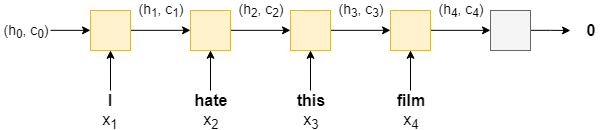


#### We are also using bidirectional RNN. Concept is like this, while one RNN process words from first to last, another RNN will process from last to first. The hidden state (and cell state) returned by both these RNNs are stacked on top of each other in a single tensor
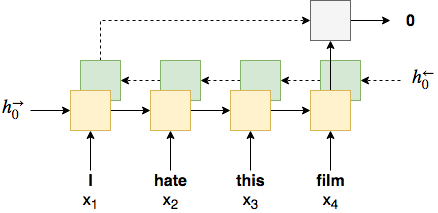

Apart from LSTM & bidirectional RNNs, we are also using Multi-Layer RNN concept here. Idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another layer. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer
Multi_Layer.png

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
         super().__init__()
         self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)  
         # We are passing idx of padded tokens so that we can avoid learning embeddings for <pad> token. 
         # <pad> tokens are irrelevant for our task here - ie predicting sentiment from movie reviews. 
         self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
         # num_layers    -> to indicate number of layers (enabling multi-layer RNN usage)
         # bidirectional -> enabling usage of bidirectional RNN
         # dropout       -> for regularization
         self.fc = nn.Linear(hidden_dim * 2, output_dim)
         # hidden_dim * 2 because of n_layers = 2. LSTM has both a forward and a backward component
         self.dropout = nn.Dropout(dropout)
     
     def forward(self, text, text_lengths):  #We are passing the lengths of our sentences to use packed padded sequences, Hence 'text_lengths'.
         # Each batch will have 64 sentences (batch_size), these tensors will be sorted on ascending order & batch will be assigned the length 
         # of longest sentence. Example as below:
         '''
         print(text.shape) --> torch.Size([371, 64])
         print(text_lengths.shape, text_lengths) --> torch.Size([64]) tensor([371, 371, 371, 371, 371, 371, 371, 370, 370, 370, 370, 370, 370, 370,
         370, 370, 370, 370, 370, 370, 369, 369, 369, 369, 369, 368, 368, 367,
         367, 367, 367, 367, 367, 367, 366, 365, 365, 365, 365, 365, 365, 365,
         365, 365, 365, 365, 364, 364, 364, 364, 364, 363, 363, 363, 363, 363,
         363, 363, 363, 363, 363, 363, 362, 362], device='cuda:0')
         '''

         #text = [sentence len, batch size] --> eg: [900, 64] means 64 sentences with 900 words each. Length of sentence will vary for each batch.
         embedded = self.dropout(self.embedding(text))
         #embedded = [sentence len, batch size, emb dim] --> [900, 64, 100] adding one more dimension for embed dimension
         
         #pack sequence.Packs a Tensor containing padded sequences of variable length.
         packed_embedded               = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
         packed_output, (hidden, cell) = self.rnn(packed_embedded) #packed_output -> packed sequence, (hidden, cell) -> tensors 
         #unpack sequence to transform from a packed sequence to a tensor. Output over padding tokens are zero tensors. 
         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
         #output = [sentence len, batch size, hid dim * num directions]
         # eg: output.shape, output_lengths.shape ---> torch.Size([165, 64, 512]) torch.Size([64])
         
         #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout
         hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
         #hidden = [batch size, hid dim * num directions]

         return self.fc(hidden)  

In [ ]:
input_dim = len(txt.vocab)   # 25002
embedding_dim = 100          # EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier (glove.6B.100d) 
hidden_dim    = 256
output_dim    = 1            # only 2 values - pos or neg as this is sentiment analysis
n_layers      = 2 
bidirectional = True
dropout       = 0.5
pad_idx       = txt.vocab.stoi[txt.pad_token]   #we are finding index of pad token i.e. we are finiding index of <pad> in vocabulary we built

model = RNN(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


#### Copying the pre-trained word embeddings (txt.vocab that we built using 'build_vocab') we loaded earlier into the embedding layer of our model

In [ ]:
pretrained_embeddings = txt.vocab.vectors
print(pretrained_embeddings.shape)
print(txt.vocab.vectors.shape)

torch.Size([25002, 100])
torch.Size([25002, 100])


#### Replace the initial weights of the embedding layer with the pre-trained embeddings.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.4460,  0.0172, -0.7685,  ...,  0.7648,  0.3600,  0.5059],
        [ 0.0467, -0.0117,  0.4367,  ..., -0.1759,  0.1154, -0.2225],
        [-1.4887, -0.1156, -1.0990,  ..., -0.2025,  0.2831, -0.6731]])

##### Manually setting rows corresponding to 'unk' and 'pad' in the embedding weights matrix to zeros.

In [ ]:
unk_idx = txt.vocab.stoi[txt.unk_token]
print('unk_idx, txt.unk_token :', unk_idx, txt.unk_token)
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)
print(model.embedding.weight.data.shape)

unk_idx, txt.unk_token : 0 <unk>
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.4460,  0.0172, -0.7685,  ...,  0.7648,  0.3600,  0.5059],
        [ 0.0467, -0.0117,  0.4367,  ..., -0.1759,  0.1154, -0.2225],
        [-1.4887, -0.1156, -1.0990,  ..., -0.2025,  0.2831, -0.6731]])
torch.Size([25002, 100])


##### SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. Hence using Adam in this example

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for idx, batch in enumerate(iterator):       
        optimizer.zero_grad()      
        text, text_lengths = batch.text 
        text_lengths       = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        predictions        = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc  = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()    

    return epoch_loss / len(iterator), epoch_acc / len(iterator)   

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(iterator):
            text, text_lengths = batch.text   
            text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')        
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc  = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)        

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
n_epochs = 20
best_valid_loss = float('inf')

for epoch in range(5, n_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Upgraded_Senti_Analysis.pt')
       
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.283 | Train Acc: 88.60%
	 Val. Loss: 0.384 |  Val. Acc: 85.30%
Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.226 | Train Acc: 91.32%
	 Val. Loss: 0.284 |  Val. Acc: 88.63%
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.186 | Train Acc: 93.05%
	 Val. Loss: 0.283 |  Val. Acc: 89.24%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.176 | Train Acc: 93.50%
	 Val. Loss: 0.312 |  Val. Acc: 89.04%
Epoch: 10 | Epoch Time: 0m 45s
	Train Loss: 0.146 | Train Acc: 94.64%
	 Val. Loss: 0.273 |  Val. Acc: 89.89%
Epoch: 11 | Epoch Time: 0m 45s
	Train Loss: 0.128 | Train Acc: 95.52%
	 Val. Loss: 0.322 |  Val. Acc: 88.90%
Epoch: 12 | Epoch Time: 0m 45s
	Train Loss: 0.119 | Train Acc: 95.77%
	 Val. Loss: 0.370 |  Val. Acc: 89.56%
Epoch: 13 | Epoch Time: 0m 45s
	Train Loss: 0.102 | Train Acc: 96.47%
	 Val. Loss: 0.361 |  Val. Acc: 89.81%
Epoch: 14 | Epoch Time: 0m 45s
	Train Loss: 0.093 | Train Acc: 96.79%
	 Val. Loss: 0.339 |  Val. Acc: 89.62%
Epoch: 15 | Epoch T

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Upgraded_Senti_Analysis.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.288 | Test Acc: 88.60%


##### Giving user input to get the sentiment back. Please note that we trained on movie review comments, hence input also should be similar text.

In [ ]:
import spacy
nlp = spacy.load('en')  #'en' is language_id that indicates english

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]   # tokenizing the sentence
    indexed = [txt.vocab.stoi[t] for t in tokenized]  # indexes the tokens by converting them into their integer representation from our vocabulary
    length  = [len(indexed)]   # gets the length of our sequence
    tensor  = torch.LongTensor(indexed).to(device)  # converts 'indexed' which is a Python list into a PyTorch tensor
    tensor = tensor.unsqueeze(1)  # adding batch dimension to feed it to GPU
    length_tensor = torch.LongTensor(length)  # converts the 'length' into a tensor
    prediction    = torch.sigmoid(model(tensor, length_tensor)) # Using sigmoid to keep the predictions between 0 & 1
    return prediction.item()

In [ ]:
predict_sentiment(model, "pathetic movie")

0.05868624523282051

In [ ]:
predict_sentiment(model, "a pathetic movie")  # Just adding 'a' dropped the score significantly

0.00686532212421298

In [ ]:
predict_sentiment(model, "simply superb")

0.9830096364021301

In [ ]:
predict_sentiment(model, "one time watch")

0.8993024826049805

In [ ]:
predict_sentiment(model, "not that bad")  # ------> # This is a problem. Negative words 'not', 'bad' etc. are bringing the score down

0.00828575436025858